In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sn
import os
os.environ['PYTHONHASHSEED']=str(42)
%matplotlib inline
import uuid
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, top_k_accuracy_score, classification_report, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import time
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)
   
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-58bae768-a281-bdf6-666d-34e39119c01d)


In [3]:
# import os
# from tensorflow.python.profiler import profiler_client

# tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
# print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

In [4]:
# Detect and init the TPU
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [5]:
DATASET_PARENT_FOLDER = "/content/drive/MyDrive/Personal_Project_Datasets/Higgs/chunked_higgs"

In [6]:
all_sets_id = [1,2,3,4,5,6,7,8,9,10,11]
train_set_id_p1 = [2,3,4,5,6] # Includes the valid set already
train_set_id_p2 = [7,8,9,10,11] # Includes the valid set already
test_set_id = [1]

In [7]:
# # Model

# # 10-L Deep-NN
# def deepNN_model_creator(input_shape):
#     model = keras.Sequential([
#     layers.BatchNormalization(input_shape=input_shape),
#     layers.Dense(512, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(1024, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(2048, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(2048, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(1024, kernel_regularizer='l2', activation='relu'),

#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(1024, kernel_regularizer='l2', activation='relu'),

#     layers.BatchNormalization(),
#     layers.Dense(2048, kernel_regularizer='l2', activation='relu'),

#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(2048, kernel_regularizer='l2', activation='relu'),

#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(4096, kernel_regularizer='l2', activation='relu'),

#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(4096, kernel_regularizer='l2', activation='relu'),

#     layers.BatchNormalization(),
#     layers.Dense(2048, kernel_regularizer='l2', activation='relu'),

#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(2048, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(1024, kernel_regularizer='l2', activation='relu'),

#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(1024, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(512, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(512, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(128, kernel_regularizer='l2', activation='relu'),
        
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(128, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dense(1, activation='sigmoid'),
#     ])
    
#     model.compile(
#         optimizer='adam',
#         loss='binary_crossentropy',
#         metrics=['binary_accuracy'],
#     )
#     return model

# def shallowNN_model_creator(input_shape):
#     model = keras.Sequential([
#     layers.BatchNormalization(input_shape=input_shape),
#     layers.Dense(512, kernel_regularizer='l2', activation='relu'),
    
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(1, activation='sigmoid'),
#     ])
    
#     model.compile(
#         optimizer='adam',
#         loss='binary_crossentropy',
#         metrics=['binary_accuracy'],
#     )
#     return model

In [8]:
# Model Configuration
UNITS = 2 ** 11 # 2048
ACTIVATION = 'relu'
DROPOUT = 0.1

# Training Configuration
BATCH_SIZE_PER_REPLICA = 2 ** 11 # powers of 128 are best
steps_per_execution = 256

def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

def dense_block_creator(input_shape):
    with strategy.scope():
        # Wide Network
        wide = keras.experimental.LinearModel()

        # Deep Network
        inputs = keras.Input(shape=input_shape)
        x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
        x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
        x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
        x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
        x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
        outputs = layers.Dense(1)(x)
        deep = keras.Model(inputs=inputs, outputs=outputs)
        
        # Wide and Deep Network
        wide_and_deep = keras.experimental.WideDeepModel(
            linear_model=wide,
            dnn_model=deep,
            activation='sigmoid',
        )

        wide_and_deep.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['AUC', 'binary_accuracy'],
            experimental_steps_per_execution=steps_per_execution,
        )
        return wide_and_deep

In [9]:
# for shallow NN, use name 'shallowNN'
# for deep NN, use name 'deepNN'

reset_random_seeds()
def model_trainer(model_to_fit, X_train, y_train, epochs, batch_size, validation_data, model_custom_name):
    
    """
        model_to_fit: model to be trained
        epochs: no. of epochs
        batch_size: no. of batch size
        validation_data: (X_valid, y_valid)
        model_custom_name: create your own name
    """
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/{}".format(model_custom_name), 
        monitor="val_loss",
        verbose=1, 
        save_best_only=True,
        mode="min"
    )

    # early_stopping = callbacks.EarlyStopping(
    #     patience=2,
    #     min_delta=0.001,
    #     restore_best_weights=True,
    # )

    lr_schedule = callbacks.ReduceLROnPlateau(
        patience=0,
        factor=0.2,
        min_lr=0.001,
    )

    model_to_fit = model_to_fit
    history = model_to_fit.fit(
        X_train, y_train,
        validation_data=validation_data,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint, lr_schedule],
    )

    # model_to_fit.save("/content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/{}".format(model_custom_name))
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
    history_frame.loc[:, ['auc', 'val_auc']].plot(title='AUC');

In [10]:
# Data Splitting and Training
from tensorflow.keras.models import load_model

reset_random_seeds()

# For Part 1 only
def train_iterator(model_custom_name):
    for i in train_set_id_p1:
        print("----------Dataset: output_{}.csv----------".format(i))
        higgs_train = pd.read_csv(os.path.join(DATASET_PARENT_FOLDER, "output_{}.csv".format(i)))
        X = higgs_train.copy()
        y = X.pop("1.000000000000000000e+00")

        scaler_folder = "/content/drive/MyDrive/Personal_Project_Datasets/Higgs/scaler/"
        if not os.path.exists(scaler_folder):
            os.mkdir(scaler_folder)
            
        scaler_filename = "higgs_scaler.sav"
        scaler_path = os.path.join(scaler_folder,scaler_filename)
        if os.path.exists(scaler_path):
            os.remove(scaler_path) # Delete to replace the existing
       
        scaler = MinMaxScaler()
        scaler.fit(X)
        joblib.dump(scaler,scaler_path)
        
        scaler = joblib.load(open(scaler_path, "rb"))
        X = scaler.transform(X)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=100000/1000000, random_state=42)
        validation_data = (X_valid, y_valid)
        input_shape = [X_train.shape[1]]
        print(input_shape)

        if os.path.exists("/content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/{}".format(model_custom_name)):
            model_to_fit = load_model("/content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/{}".format(model_custom_name))
            print("model loaded")
        else:
            model_to_fit = dense_block_creator(input_shape)
            print("model initialized")
        indiv_training_start = time.perf_counter()
        model_trainer(model_to_fit=model_to_fit, X_train=X_train, y_train=y_train,epochs=20,batch_size=512, validation_data=validation_data, model_custom_name=model_custom_name)
        indiv_training_end = time.perf_counter()
        print("Training time for output_{}.csv data".format(i), indiv_training_end-indiv_training_start, "seconds")

----------Dataset: output_2.csv----------
[28]
model initialized
Epoch 1/20
1758/1758 [==============================] - ETA: 0s - loss: 0.6155 - auc: 0.7219 - binary_accuracy: 0.6606
Epoch 1: val_loss improved from inf to 0.57157, saving model to /content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/denseblock_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/denseblock_model/assets
1758/1758 [==============================] - 48s 27ms/step - loss: 0.6155 - auc: 0.7219 - binary_accuracy: 0.6606 - val_loss: 0.5716 - val_auc: 0.7719 - val_binary_accuracy: 0.6993 - lr: 0.0010
Epoch 2/20
1758/1758 [==============================] - ETA: 0s - loss: 0.5493 - auc: 0.7914 - binary_accuracy: 0.7167
Epoch 2: val_loss improved from 0.57157 to 0.55179, saving model to /content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/denseblock_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Personal_Project

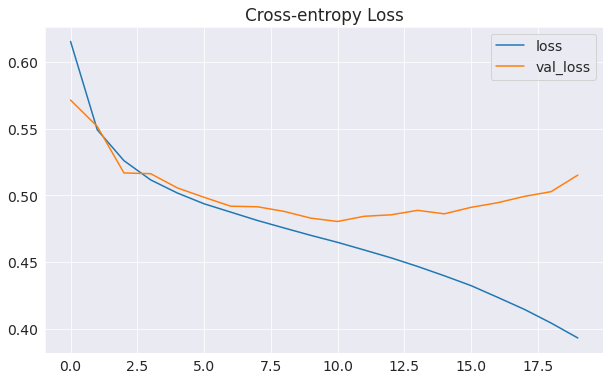

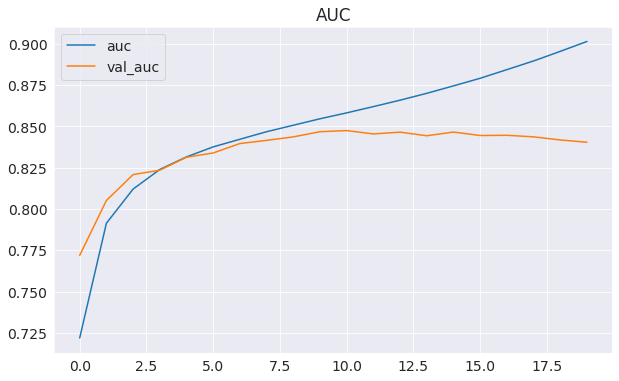

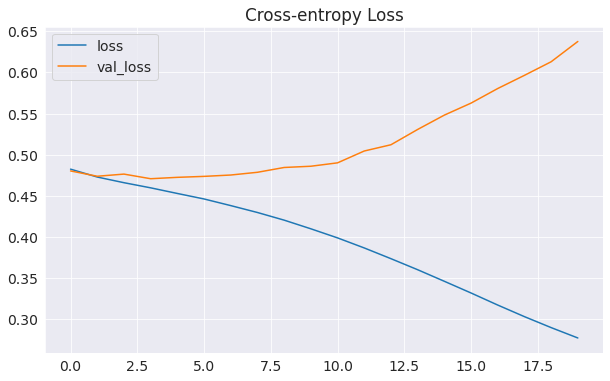

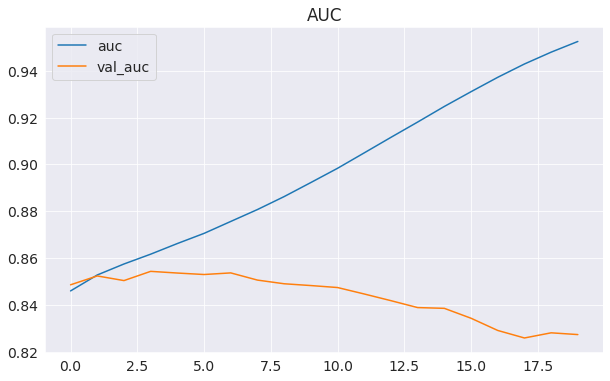

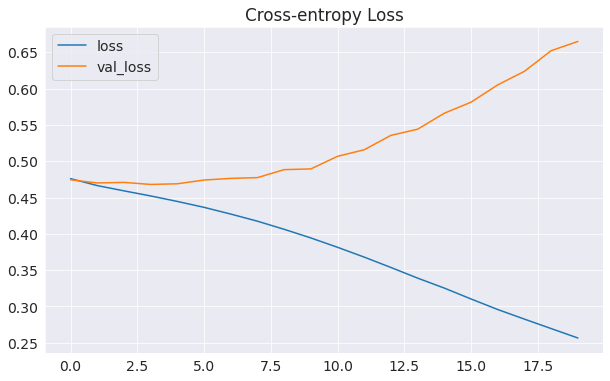

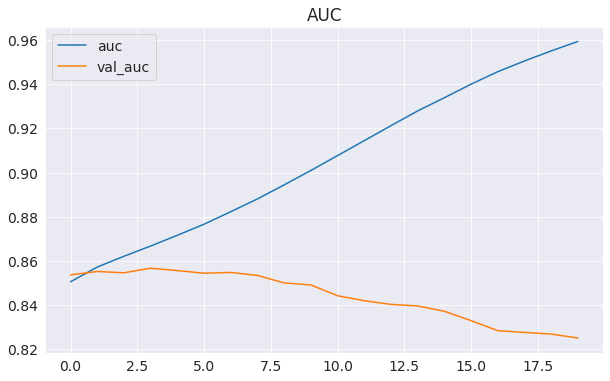

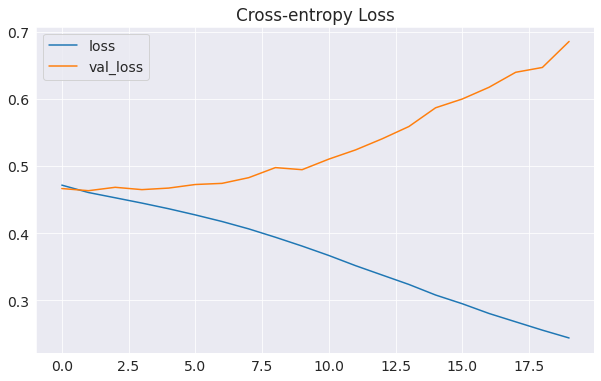

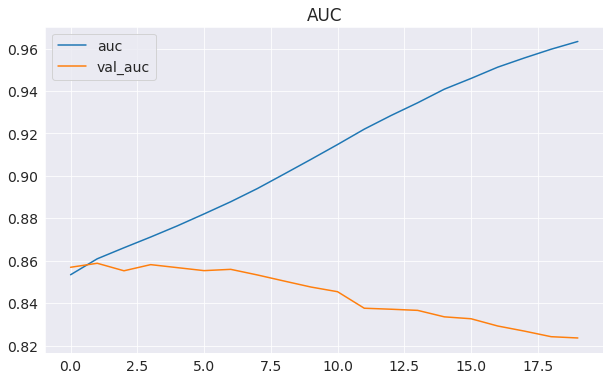

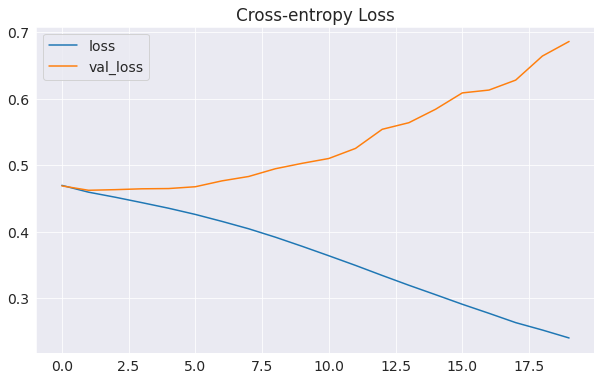

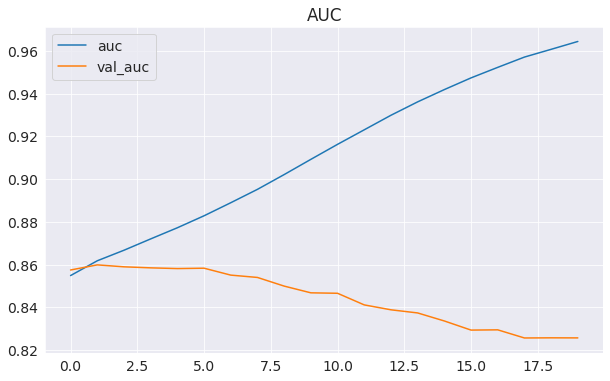

In [11]:
reset_random_seeds()
whole_training_start = time.perf_counter()
train_iterator(model_custom_name="denseblock_model")
whole_training_end = time.perf_counter()
print("Training time for the whole data", whole_training_end-whole_training_start, "seconds")

In [16]:
reset_random_seeds()

# For Part 2 only
def train_iterator2(model_custom_name):
    for i in train_set_id_p2:
        print("----------Dataset: output_{}.csv----------".format(i))
        higgs_train = pd.read_csv(os.path.join(DATASET_PARENT_FOLDER, "output_{}.csv".format(i)))
        X = higgs_train.copy()
        y = X.pop("1.000000000000000000e+00")

        scaler_folder = "/content/drive/MyDrive/Personal_Project_Datasets/Higgs/scaler/"
        if not os.path.exists(scaler_folder):
            os.mkdir(scaler_folder)
            
        scaler_filename = "higgs_scaler.sav"
        scaler_path = os.path.join(scaler_folder,scaler_filename)
        if os.path.exists(scaler_path):
            os.remove(scaler_path) # Delete to replace the existing
       
        scaler = MinMaxScaler()
        scaler.fit(X)
        joblib.dump(scaler,scaler_path)
        
        scaler = joblib.load(open(scaler_path, "rb"))
        X = scaler.transform(X)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=100000/1000000, random_state=42)
        validation_data = (X_valid, y_valid)
        input_shape = [X_train.shape[1]]

        if os.path.exists("/content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/{}".format(model_custom_name)):
            model_to_fit = load_model("/content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/{}".format(model_custom_name))
            print("model loaded")
        else:
            model_to_fit = dense_block_creator(input_shape)
            print("model initialized")
        indiv_training_start = time.perf_counter()
        model_trainer(model_to_fit=model_to_fit, X_train=X_train, y_train=y_train,epochs=20,batch_size=512, validation_data=validation_data, model_custom_name=model_custom_name)
        indiv_training_end = time.perf_counter()
        print("Training time for output_{}.csv data".format(i), indiv_training_end-indiv_training_start, "seconds")

----------Dataset: output_7.csv----------
model loaded
Epoch 1/20
1757/1758 [============================>.] - ETA: 0s - loss: 0.4660 - auc: 0.8576 - binary_accuracy: 0.7731
Epoch 1: val_loss improved from inf to 0.46024, saving model to /content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/denseblock_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/denseblock_model/assets
1758/1758 [==============================] - 47s 26ms/step - loss: 0.4660 - auc: 0.8576 - binary_accuracy: 0.7731 - val_loss: 0.4602 - val_auc: 0.8615 - val_binary_accuracy: 0.7755 - lr: 0.0010
Epoch 2/20
1756/1758 [============================>.] - ETA: 0s - loss: 0.4560 - auc: 0.8643 - binary_accuracy: 0.7794
Epoch 2: val_loss did not improve from 0.46024
1758/1758 [==============================] - 41s 23ms/step - loss: 0.4560 - auc: 0.8643 - binary_accuracy: 0.7795 - val_loss: 0.4658 - val_auc: 0.8582 - val_binary_accuracy: 0.7726 - lr: 0.0

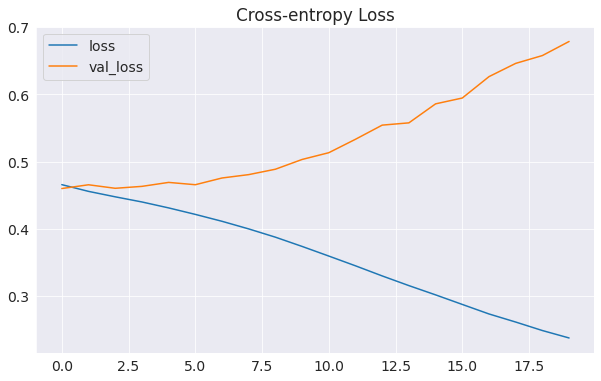

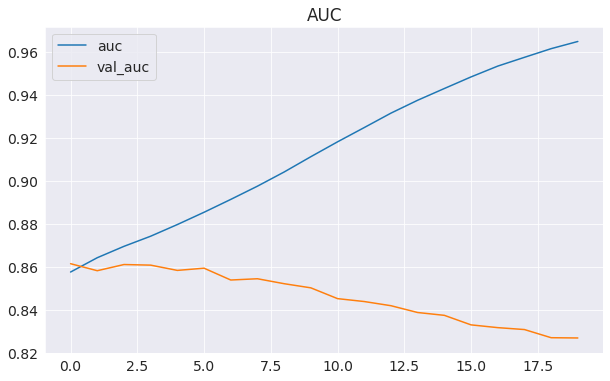

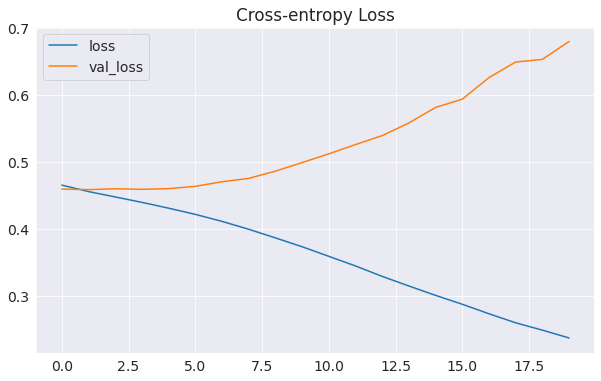

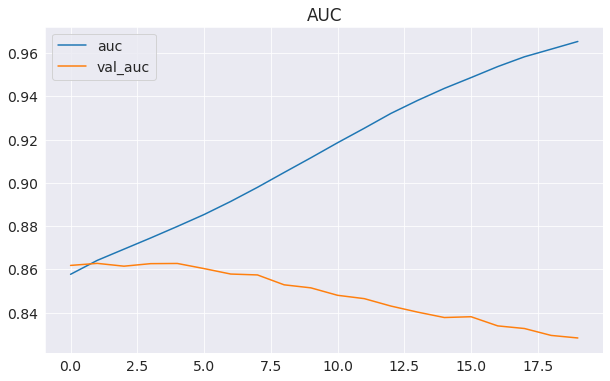

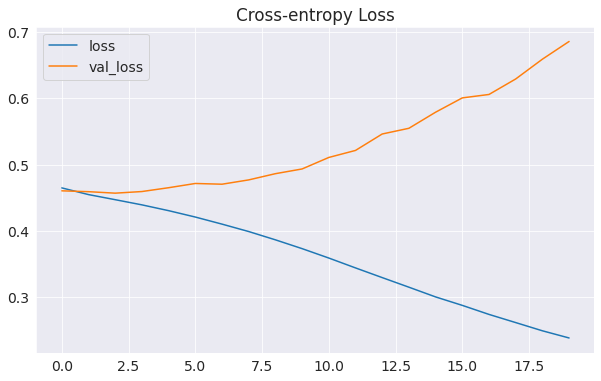

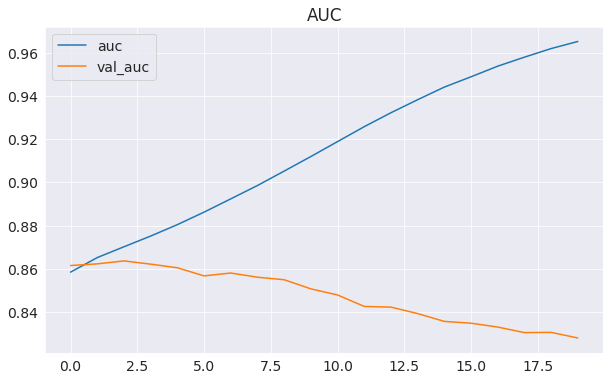

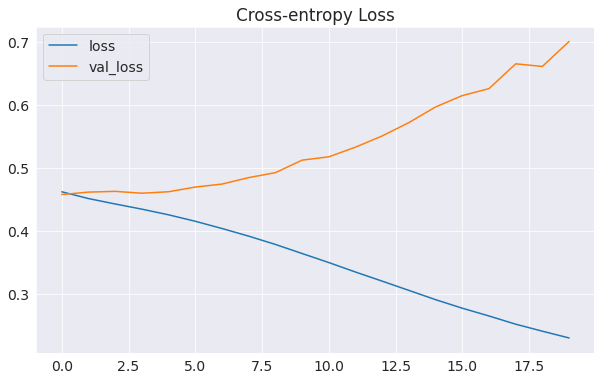

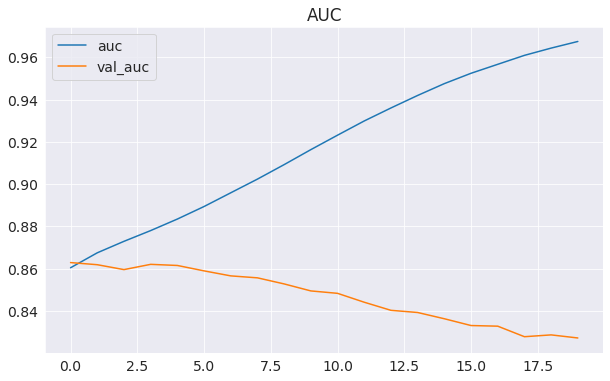

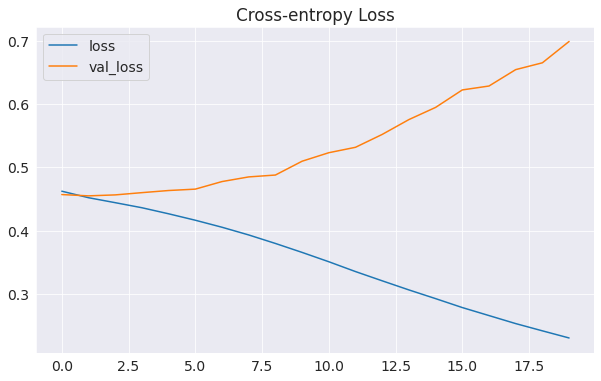

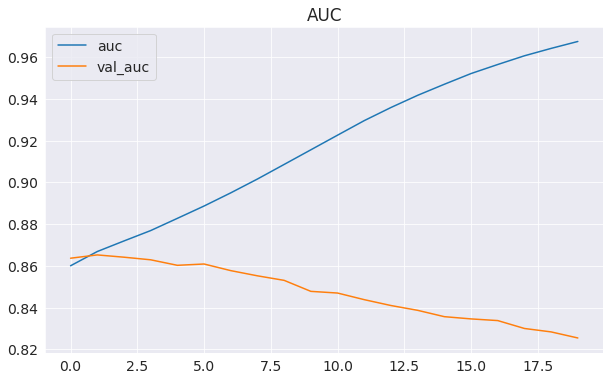

In [17]:
reset_random_seeds()
whole_training_start = time.perf_counter()
train_iterator2(model_custom_name="denseblock_model")
whole_training_end = time.perf_counter()
print("Training time for the whole data", whole_training_end-whole_training_start, "seconds")

In [23]:
reset_random_seeds()
def predictor(model_path, test_path, scaler_path):
    higgs_test = pd.read_csv(test_path)
    X_test = higgs_test.copy()
    y_test = X_test.pop("1.000000000000000000e+00")
    
    scaler = joblib.load(open(scaler_path, "rb"))
    X_test = scaler.transform(X_test)
    
    model = load_model(model_path)
    
    prediction_start = time.perf_counter()
    predictions = model.predict(X_test)
    prediction_end = time.perf_counter()
    print("Prediction Time :", prediction_end - prediction_start, " seconds")
    
    predictions = [0 if x < 0.5 else 1 for x in predictions]
    
    f1_score_model = f1_score(predictions, y_test, average="binary")
    accuracy_score_model = accuracy_score(predictions, y_test)
    precision_score_model = precision_score(predictions, y_test)
    recall_score_model = recall_score(predictions, y_test)
    roc_auc_score_model = roc_auc_score(predictions, y_test)
    roc_curve_model = roc_curve(predictions, y_test)

    fpr, tpr, thresholds = roc_curve(predictions, y_test)
    
    top_k_accuracy_score_model = top_k_accuracy_score(predictions, y_test)
    classification_report_model = classification_report(predictions, y_test)

    auc_model = auc(fpr, tpr)
    
    print("f1_score: ", f1_score_model)
    print("accuracy_score: ", accuracy_score_model)
    print("precision_score: ", precision_score_model)
    print("recall_score: ", recall_score_model)
    print("roc_auc_score: ", roc_auc_score_model)
    print("roc_curve: ", roc_curve_model)
    print("top_k_accuracy_score: ", top_k_accuracy_score_model)
    print("auc: ", auc_model)
    print("-------------classification_report-------------- ")
    print(classification_report_model)
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(y_test, predictions)

    ax = plt.axes()
    sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax)
    ax.set_title('{}'.format(model_path), size=12)
    ax.xaxis.set_ticklabels(['Non-Higgs', 'Higgs']); ax.yaxis.set_ticklabels(['Non-Higgs', 'Higgs']);
    ax.set_xlabel('Reality');ax.set_ylabel('Prediction');
    plt.show()

Prediction Time : 82.21901613500086  seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1751: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  UndefinedMetricWarning,


f1_score:  0.7939094460609472
accuracy_score:  0.781706
precision_score:  0.7918878858819608
recall_score:  0.795941354080889
roc_auc_score:  0.7808533784999193
roc_curve:  (array([0.       , 0.2342346, 1.       ]), array([0.        , 0.79594135, 1.        ]), array([2., 1., 0.]))
top_k_accuracy_score:  1.0
auc:  0.7808533784999193
-------------classification_report-------------- 
              precision    recall  f1-score   support

           0       0.77      0.77      0.77    471745
           1       0.79      0.80      0.79    528255

    accuracy                           0.78   1000000
   macro avg       0.78      0.78      0.78   1000000
weighted avg       0.78      0.78      0.78   1000000



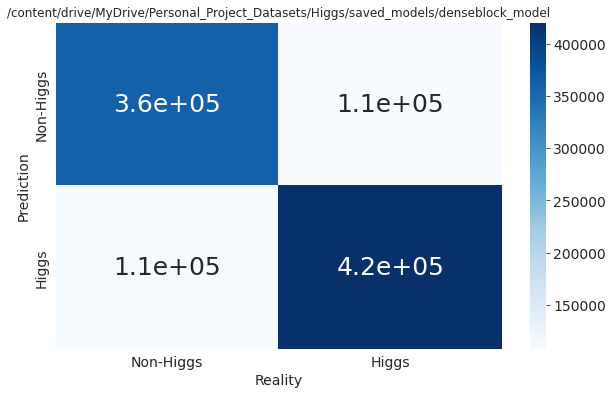

In [24]:
reset_random_seeds()
test_path = os.path.join(DATASET_PARENT_FOLDER, "output_1.csv")
model_path = "/content/drive/MyDrive/Personal_Project_Datasets/Higgs/saved_models/denseblock_model"
scalar_path = "/content/drive/MyDrive/Personal_Project_Datasets/Higgs/scaler/higgs_scaler.sav"
predictor(model_path, test_path, scalar_path)

In [14]:
# Sources:
# https://arxiv.org/abs/1402.4735